In [1]:
import numpy as np
import scipy as sp
import sdme_logloss as sdme

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# First we generate some stimulus:
stim_dim = 16*16
stim_len = 20000
stim = np.random.randn(stim_dim, stim_len)
stim = stim / np.max(stim)

In [3]:
# Next, we generate (first order) population receptive fields

N = 4  # Number of neurons
p=0.1
fo_rf = np.ones((N, stim_dim))
fo_rf[np.random.rand(N, stim_dim) > p] = 0
fo_rf[0, :] *= 0

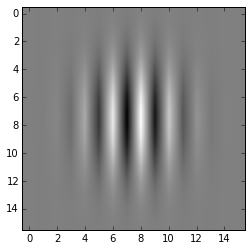

In [4]:
# Generate Second Order Receptive fields

x = np.linspace(-1.0, 1.0, 16)
y = x
X, Y = np.meshgrid(x, y)
gb = np.exp(-(X**2 + Y**2)/0.25)*np.sin(2*np.pi*4*X)
plt.figure()
plt.set_cmap('gray')
plt.imshow(gb)

gbvec = np.squeeze(np.reshape(gb, (stim_dim, 1)))
eigvecmat = np.random.randn(stim_dim, stim_dim)
eigvecmat[0, :] = gbvec
eigvalmat = np.identity(stim_dim)/10.0
eigvalmat[0,0] = 1.0
stc_model = np.dot(np.linalg.inv(eigvecmat), np.dot(eigvalmat, eigvecmat))
stc_model_cube = np.zeros((N, stim_dim, stim_dim))
stc_model_cube[0, :, :] = stc_model



In [5]:
# Generate matrix of all possible population states
stmat = sdme.get_states(N)


In [6]:
# Next, we generate correlations between the neurons
p2 = 0.5
neu_corr = np.random.randn(N, N)
neu_corr[np.random.rand(N, N) > p2] = 0
neu_corr = (neu_corr + np.transpose(neu_corr))/2.0 

In [7]:
# Compute the probability over states
outcorr = np.einsum('ijk,jt,kt->it', stc_model_cube, stim, stim)
corr_states = np.diag(np.dot(np.dot(np.transpose(stmat), neu_corr), stmat))

E = np.dot(np.dot(np.transpose(stmat),fo_rf),stim) + np.transpose(np.tile(corr_states, (stim_len, 1))) + np.dot(np.transpose(stmat), outcorr)
probs = np.exp(E) / np.sum(np.exp(E),0 )
probs[np.isnan(probs)] = 1.0

In [8]:
# Sanity Check
print(np.sum(probs, 0))
#print(E)
test1 = np.dot(np.dot(np.transpose(stmat),fo_rf),stim)
print(test1)
test2 = np.dot(np.transpose(stmat), outcorr)
print(test2)

[ 1.  1.  1. ...,  1.  1.  1.]
[[  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  1.14258265e+00   6.81242317e-02   2.08669791e-01 ...,   9.57776478e-01
   -1.95183016e+00   1.21924893e-03]
 ..., 
 [  2.30090474e+00   2.32015185e+00   2.49966199e+00 ...,  -1.14296585e+00
   -3.16305669e-01  -1.50153018e-01]
 [  3.44348739e+00   2.38827608e+00   2.70833178e+00 ...,  -1.85189373e-01
   -2.26813583e+00  -1.48933769e-01]
 [  3.44348739e+00   2.38827608e+00   2.70833178e+00 ...,  -1.85189373e-01
   -2.26813583e+00  -1.48933769e-01]]
[[ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.05159553 -4.59901398  1.83962875 ...,  2.02608865  2.17241273
   3.07755651]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 ..., 
 [ 1.05159553 -4.59901398  1.83962875 ..

In [9]:
# Generate Responses
# cumulative probs
probs_c = np.concatenate((np.zeros((1, stim_len)), np.cumsum(probs, 0)), 0)

# generate random vec  (COULD BE MADE MORE EFFICIENT)
nreps = 20
pop_response = np.zeros((N, stim_len, nreps))
for rep in range(nreps):
    prb = np.random.rand(1, stim_len)
    outcomes = 1*np.logical_and(probs_c[0:-1, :] < prb, probs_c[1:, :] > prb)
    #np.concatenate((outcomesav, outcomes))
    pop_response_this_rep = np.dot(stmat, outcomes)
    pop_response[:, :, rep] = pop_response_this_rep



In [10]:
pop_response_rep = pop_response
test_sta = sdme.data_to_sta(pop_response_rep, stim)
np.shape(test_sta)
np.amax(test_sta)

0.0095068685982806472

In [19]:
print(pop_response_rep)



[[[ 1. -1.  1. ..., -1. -1.  1.]
  [-1. -1. -1. ..., -1. -1. -1.]
  [-1.  1.  1. ...,  1.  1.  1.]
  ..., 
  [ 1.  1.  1. ...,  1.  1.  1.]
  [ 1.  1.  1. ...,  1.  1.  1.]
  [ 1.  1.  1. ...,  1.  1.  1.]]

 [[ 1. -1.  1. ...,  1. -1.  1.]
  [ 1. -1.  1. ...,  1. -1. -1.]
  [ 1.  1.  1. ..., -1.  1. -1.]
  ..., 
  [ 1.  1. -1. ...,  1.  1. -1.]
  [-1. -1. -1. ..., -1. -1. -1.]
  [ 1. -1. -1. ..., -1.  1.  1.]]

 [[ 1.  1.  1. ...,  1.  1.  1.]
  [ 1.  1.  1. ..., -1.  1.  1.]
  [ 1.  1.  1. ...,  1.  1.  1.]
  ..., 
  [-1. -1.  1. ...,  1.  1.  1.]
  [ 1.  1.  1. ..., -1. -1. -1.]
  [ 1.  1.  1. ...,  1.  1.  1.]]

 [[-1.  1.  1. ...,  1.  1.  1.]
  [ 1.  1.  1. ...,  1.  1.  1.]
  [ 1.  1.  1. ..., -1. -1. -1.]
  ..., 
  [ 1. -1.  1. ...,  1. -1.  1.]
  [ 1. -1. -1. ..., -1. -1. -1.]
  [-1. -1. -1. ..., -1. -1. -1.]]]


In [20]:
print(pop_response)

[[[ 1. -1.  1. ..., -1. -1.  1.]
  [-1. -1. -1. ..., -1. -1. -1.]
  [-1.  1.  1. ...,  1.  1.  1.]
  ..., 
  [ 1.  1.  1. ...,  1.  1.  1.]
  [ 1.  1.  1. ...,  1.  1.  1.]
  [ 1.  1.  1. ...,  1.  1.  1.]]

 [[ 1. -1.  1. ...,  1. -1.  1.]
  [ 1. -1.  1. ...,  1. -1. -1.]
  [ 1.  1.  1. ..., -1.  1. -1.]
  ..., 
  [ 1.  1. -1. ...,  1.  1. -1.]
  [-1. -1. -1. ..., -1. -1. -1.]
  [ 1. -1. -1. ..., -1.  1.  1.]]

 [[ 1.  1.  1. ...,  1.  1.  1.]
  [ 1.  1.  1. ..., -1.  1.  1.]
  [ 1.  1.  1. ...,  1.  1.  1.]
  ..., 
  [-1. -1.  1. ...,  1.  1.  1.]
  [ 1.  1.  1. ..., -1. -1. -1.]
  [ 1.  1.  1. ...,  1.  1.  1.]]

 [[-1.  1.  1. ...,  1.  1.  1.]
  [ 1.  1.  1. ...,  1.  1.  1.]
  [ 1.  1.  1. ..., -1. -1. -1.]
  ..., 
  [ 1. -1.  1. ...,  1. -1.  1.]
  [ 1. -1. -1. ..., -1. -1. -1.]
  [-1. -1. -1. ..., -1. -1. -1.]]]


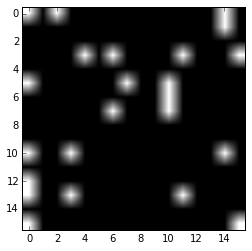

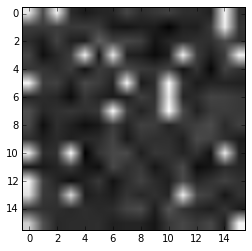

In [13]:
rf0_sq = np.reshape(fo_rf[1,:], (16, 16))
rf0_est_sq= np.reshape(test_sta[1,:], (16, 16))

plt.figure()
plt.imshow(rf0_sq)

plt.figure()
plt.imshow(rf0_est_sq)

In [14]:
test_stc = sdme.data_to_stc(pop_response_rep, stim)
np.shape(test_stc)
np.amax(test_stc)

0.030145742829075971

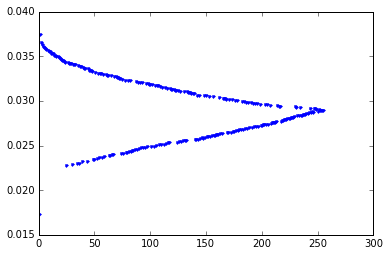

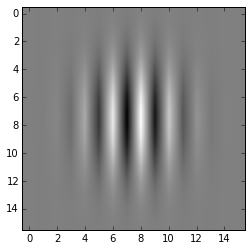

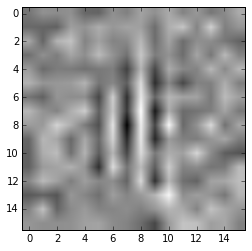

In [15]:
eigvals_0, eigvecs_0 = np.linalg.eig(test_stc[0, :, :])
plt.figure()
plt.plot(eigvals_0, '.')

eigvec_0_0_sq = np.reshape(eigvecs_0[:, 0], (16, 16))

plt.figure()
plt.imshow(gb)

plt.figure()
plt.imshow(eigvec_0_0_sq)

In [17]:
def data_to_cov2(spikes):
    # Estimate the neuron-neuron covariance
    # spikes: N x stimlen x nrepeats
    N, stimlen, nreps = np.shape(spikes)
    
    spikes = 1.0*np.squeeze(np.sum(spikes,2))
    spikes -= np.transpose(np.tile(np.mean(spikes, 1), (stimlen, 1)))
    print(spikes)
    print(np.shape(spikes))
    cov = np.tensordot(spikes, np.transpose(spikes), 1) / (1.0*nreps*stimlen)
    cov -= np.diagflat(np.diag(cov))
    return cov

In [16]:
test_cov = sdme.data_to_cov(pop_response_rep)
np.shape(test_cov)
np.amax(test_cov)
test_cov

[[  0.5835  -14.4165    2.5835  ...,   4.5835    3.5835    4.5835 ]
 [  3.0486    3.0486   -0.9514  ...,   4.0486   -7.9514   -0.9514 ]
 [  4.37855   0.37855   4.37855 ...,   0.37855   0.37855  -0.62145]
 [  6.9861    7.9861    0.9861  ...,  -1.0139   -7.0139   -7.0139 ]]
(4, 20000)


array([[ 0.        , -0.0184604 ,  0.2831283 , -0.38584697],
       [-0.0184604 ,  0.        , -0.07168988,  0.10978878],
       [ 0.2831283 , -0.07168988,  0.        ,  0.21142809],
       [-0.38584697,  0.10978878,  0.21142809,  0.        ]])

In [17]:
test_emp_distrib = sdme.data_to_empirical2(pop_response_rep)
np.shape(test_emp_distrib)

(16, 20000)

In [18]:
print(np.amax(test_emp_distrib))
test_emp_distrib[:, 0:4]

0.95


array([[ 0.  ,  0.05,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.05,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.05,  0.05],
       [ 0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.05,  0.  ,  0.35,  0.1 ],
       [ 0.  ,  0.05,  0.  ,  0.  ],
       [ 0.15,  0.  ,  0.1 ,  0.1 ],
       [ 0.  ,  0.  ,  0.  ,  0.05],
       [ 0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.15,  0.  ,  0.  ],
       [ 0.05,  0.  ,  0.  ,  0.05],
       [ 0.1 ,  0.3 ,  0.05,  0.05],
       [ 0.25,  0.05,  0.2 ,  0.1 ],
       [ 0.1 ,  0.35,  0.05,  0.1 ],
       [ 0.3 ,  0.  ,  0.2 ,  0.4 ]])

In [19]:
def data_to_empirical2(spikes):
    # spikes: N x stimlen x nrepeats
    N, stimlen, nreps = np.shape(spikes)
    stmat= sdme.get_states(N)
    stmat[stmat == 0] = -1
    spikes[spikes == 0] = -1
    data_state = np.tensordot(np.transpose(stmat), spikes, 1) / (1.0*(N)) # Find which state the network is in
    data_state[data_state < 1.0] = 0
    empirical_distrib = np.sum(data_state, 2) / (1.0*nreps) # compute histogram over each rep. 
    return empirical_distrib

In [23]:
test_dist2 = data_to_empirical2(pop_response_rep)
print(np.amax(test_emp_distrib))
test_emp_distrib[:, 0:4]

0.0


array([[ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.]])

In [34]:
stmat

array([[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1],
       [0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1],
       [0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]])

In [23]:
test_logloss = sdme.sdme_logloss2(stim, test_emp_distrib, stmat, test_sta, test_stc, test_cov)

[[ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.2570885   0.28223935  0.306582   ...,  0.27424754  0.28918031
   0.27092128]
 [ 0.15820475  0.16890695  0.17547307 ...,  0.16705977  0.14757649
   0.15527699]
 ..., 
 [ 0.88692065  0.96758175  1.01051921 ...,  0.8986566   0.94408798
   0.89749085]
 [ 1.06967203  1.13588447  1.1610454  ...,  1.07310397  1.08411929
   1.06348169]
 [ 1.0844024   1.17576569  1.22526927 ...,  1.10499337  1.13094146
   1.09204483]]


In [24]:
test_logloss

1026644909.5524793

In [25]:
def sdme_loglossA(stim, resp, stmat, A, B, C):
    
    # A: Current STA model estimate N x StimDim
    # B: Current STC model estimate N x StimDim x StimDim
    # C: Current Neuron-Neuron covarariance estimate 2^N x 2^N
    # stmat: matrix of possible states
    # stim: stim matrix StimDim x StimLen
    # resp: response matrix N x SimLen   or... P(x|s) from data: 2^N x Stimlen because this is fixed for the fitting
    
    N, stimlen = np.shape(resp)
    stimdim, stimlen = np.shape(stim)
    
    # Compute the probability over states
    corr_states = np.diag(np.dot(np.dot(np.transpose(stmat), C), stmat))
    outcorr = np.einsum('ijk,jt,kt->it', B, stim, stim)
    
    E = np.dot(np.dot(np.transpose(stmat), A),stim) + np.transpose(np.tile(corr_states, (stimlen, 1))) + np.dot(np.transpose(stmat), outcorr)
    print(E)
    probs = np.exp(E) / np.sum(np.exp(E),0 )  # 2^N x StimLen 
    probs[np.isnan(probs)] = 1.0
    print(np.amax(probs))
    print(np.amin(probs))
    logprobs = np.log(probs)
    logprobs[np.isnan(logprobs)] = 0.0
    print(logprobs)
    logloss = np.diag(np.dot(np.transpose(resp), logprobs)) 
    loglosszeros = np.isnan(logloss)
    #logloss[loglosszeros] = 0.0
    logloss = -1.0*np.sum(logloss) / 1.0*stimlen
    return logloss

In [26]:
test_logloss2 = sdme_loglossA(stim, test_emp_distrib, stmat, test_sta, test_stc, test_cov)

[[ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.2570885   0.28223935  0.306582   ...,  0.27424754  0.28918031
   0.27092128]
 [ 0.15820475  0.16890695  0.17547307 ...,  0.16705977  0.14757649
   0.15527699]
 ..., 
 [ 0.88692065  0.96758175  1.01051921 ...,  0.8986566   0.94408798
   0.89749085]
 [ 1.06967203  1.13588447  1.1610454  ...,  1.07310397  1.08411929
   1.06348169]
 [ 1.0844024   1.17576569  1.22526927 ...,  1.10499337  1.13094146
   1.09204483]]
0.12525698981
0.0234972047188
[[-3.34978985 -3.40304552 -3.43326686 ..., -3.36114686 -3.37821287
  -3.35458196]
 [-3.09270135 -3.12080616 -3.12668486 ..., -3.08689932 -3.08903256
  -3.08366068]
 [-3.19158509 -3.23413857 -3.25779379 ..., -3.19408709 -3.23063638
  -3.19930497]
 ..., 
 [-2.4628692  -2.43546377 -2.42274765 ..., -2.46249026 -2.43412489
  -2.45709111]
 [-2.28011781 -2.26716105 -2.27222145 ..., -2.28804289 -2.29409358
  -2.29110027]
 [-2.26538745 -2.22727983 -2.20799759 ..., -2.25615349 

In [27]:
test_logloss2

1026644909.5524793

In [29]:
def sdme_dlogloss2(stim, stmat, dat_STA, dat_STC, dat_COV, A, B, C):
    # A: Current STA model estimate N x StimDim
    # B: Current STC model estimate N x StimDim x StimDim
    # C: Current Neuron-Neuron covarariance estimate 2^N x 2^N
    # stmat: matrix of possible states
    # stim: stim matrix StimDim x StimLen
    # dat_ : parameters estimated from data. 
    
        
    N, N2 = np.shape(stmat)
    stimdim, stimlen = np.shape(stim)
    
    # Compute the probability over states
    corr_states = np.diag(np.dot(np.dot(np.transpose(stmat), C), stmat))
    outcorr = np.einsum('ijk,jt,kt->it', B, stim, stim)
    
    E = np.dot(np.dot(np.transpose(stmat), A),stim) + np.transpose(np.tile(corr_states, (stimlen, 1))) + np.dot(np.transpose(stmat), outcorr)
    #print(E)
    probs = np.exp(E) / np.sum(np.exp(E),0 )  # 2^N x StimLen 
    
    #probs = np.expand_dims(probs, 2)
    #mod_STA = data_to_sta(probs, stim)
    #mod_STC = data_to_stc(probs, stim)
    #mod_COV = data_to_cov(probs)
    
    unit_probs = np.dot(stmat, probs)
    unit_probs_expand = np.expand_dims(unit_probs, 2)
    mod_STA = np.dot(unit_probs, np.transpose(stim))
    mod_STC = data_to_stc(unit_probs_expand, stim)
    mod_COV = data_to_cov(unit_probs_expand)
    
    df1 = dat_STA - mod_STA
    df2 = dat_STC - mod_STC
    df3 = dat_COV - mod_COV
    
    return [df1, df2, df3]
    

In [30]:
test_dlogloss = sdme_dlogloss2(stim, stmat, test_sta, test_stc, test_cov, test_sta, test_stc, test_cov)

In [31]:
test_dlogloss

[array([[-16.17190708,   4.6718445 , -18.29944751, ...,  -5.42451615,
          -9.86982532,   4.46841015],
        [-15.3176943 ,   4.46773456, -17.51509444, ...,  -5.36671869,
          -9.56988765,   4.25694815],
        [-18.57723229,   5.26155634, -20.45523886, ...,  -6.1006608 ,
         -11.06119386,   5.0348742 ],
        [-17.6901317 ,   5.0597631 , -19.78665146, ...,  -5.96718546,
         -10.71085721,   4.91611686]]),
 array([[[  3.20147136e-03,   2.42697708e-05,   4.42745241e-05, ...,
           -2.40930271e-05,  -3.74479659e-05,   1.53332075e-05],
         [  2.42697708e-05,   3.32562688e-03,   2.53677818e-05, ...,
           -2.29666288e-05,   1.28577238e-05,  -2.41171938e-05],
         [  4.42745241e-05,   2.53677818e-05,   3.39794846e-03, ...,
           -4.00989115e-05,   2.92179407e-05,  -3.50138655e-05],
         ..., 
         [ -2.40930271e-05,  -2.29666288e-05,  -4.00989115e-05, ...,
            3.41408225e-03,   3.77160872e-05,   7.16580083e-05],
         [ -3.7